In [4]:
import os
import sys
from collections import OrderedDict

In [5]:
sys.path.append("../..")

In [6]:
import spatialpy
spatialpy.__file__

'../../spatialpy/__init__.py'

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import matplotlib.pyplot as plt
import numpy

# Global Constants
MAX_X_DIM = 5.0
MIN_X_DIM = -5.0
TOL = 1e-9

In [9]:
class Edge1(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return abs(x[0] - MAX_X_DIM) < 0.05
class Edge2(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return abs(x[0] - MIN_X_DIM) < 0.05
class Middle(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return abs(x[0] - MIN_X_DIM) >= 0.05

In [251]:
class cylinderDemo3D(spatialpy.Model):
    def __init__(self, model_name="cylinder_demo3d"):
        spatialpy.Model.__init__(self, model_name)

        self.timestep_size = 1
        
        # System constants
        D_const = 0.1

        # Define Species
        A = spatialpy.Species(name="A", diffusion_constant=D_const)
        B = spatialpy.Species(name="B", diffusion_constant=D_const)
        self.add_species([A, B])

        # Define Geometry
        self.mesh = spatialpy.Mesh.read_xml_mesh('cylinder.xml')

        # Define Subdomains
        self.add_subdomain(Middle(), 1)
        self.add_subdomain(Edge1(), 2)
        self.add_subdomain(Edge2(), 3)
        
        # Restrict the movement of Chemical Species
        self.restrict(A,[1,2])
        self.restrict(B,[1,3])

        #vol = self.mesh.get_vol()
        #print("vol",vol)
        #sd = self.mesh.sd
        #left = numpy.sum(vol[sd == 2])
        #right = numpy.sum(vol[sd == 3])
        #print("left "+str(left)+" right "+str(right))
        
        k_react = spatialpy.Parameter(name="k_react", expression=1.0)
        k_creat1 = spatialpy.Parameter(name="k_creat1", 
                                     expression=200)
        k_creat2 = spatialpy.Parameter(name="k_creat2", 
                                     expression=200)
        self.add_parameter([k_react, k_creat1,k_creat2])


        # Define Reactions
        R1 = spatialpy.Reaction(reactants=None, products={A:1}, 
                                rate=k_creat1, restrict_to=2)
        R2 = spatialpy.Reaction(reactants=None, products={B:1}, 
                              rate=k_creat2, restrict_to=3)
        R3 = spatialpy.Reaction(reactants={A:1, B:1}, products=None, 
                              rate=k_react)
        self.add_reaction([R1, R2, R3])

        # Define simulation timespan
        #self.set_timesteps(1, 200)
        self.timespan(range(500))

In [252]:
model = cylinderDemo3D()

In [253]:
%time result = model.run()

CPU times: user 5.59 s, sys: 68.1 ms, total: 5.66 s
Wall time: 49.2 s


29650.0
30013.0
0.5092013833059308
0.505804729089437


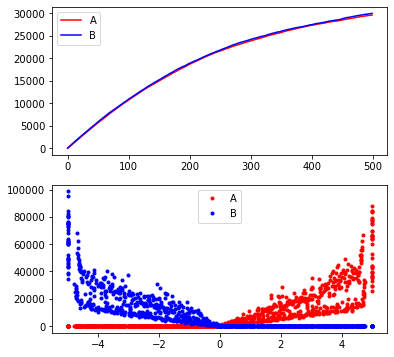

In [254]:
# Plot of the time-average spatial concentration.
x_vals = model.mesh.coordinates()[:, 0]
A_vals = numpy.sum(result.get_species("A", concentration=False, debug=False), axis=0)
B_vals = numpy.sum(result.get_species("B", concentration=False), axis=0)

A_sum = numpy.sum(result.get_species("A"), axis=1)
B_sum = numpy.sum(result.get_species("B"), axis=1)
print(A_sum[-1])
print(B_sum[-1])
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(result.get_timespan(),A_sum,'-r',label="A")
plt.plot(result.get_timespan(),B_sum,'-b',label="B")
plt.legend(loc='best')
plt.subplot(2,1,2)

vol = model.mesh.vol
sd = model.mesh.sd
print(numpy.sum(vol[sd == 2]))
print(numpy.sum(vol[sd == 3]))


plt.plot(x_vals,A_vals,'.r',x_vals,B_vals,'.b')
plt.legend(['A', 'B'],loc='best')


35032606.496848
3987999.9999939995
0.5092013833059308
0.505804729089437


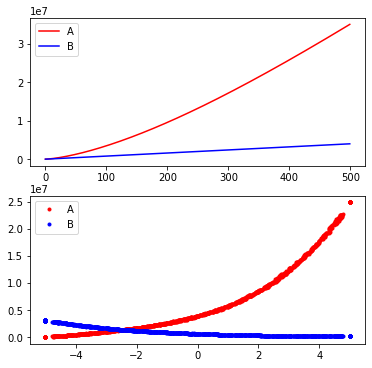

In [255]:
#deterministic (be aware of timestep)
# Plot of the time-average spatial concentration.
x_vals = model.mesh.coordinates()[:, 0]
A_vals = numpy.sum(result.get_species("A", deterministic=True, concentration=False, debug=False), axis=0)
B_vals = numpy.sum(result.get_species("B", deterministic=True, concentration=False), axis=0)

A_sum = numpy.sum(result.get_species("A", deterministic=True), axis=1)
B_sum = numpy.sum(result.get_species("B", deterministic=True), axis=1)
print(A_sum[-1])
print(B_sum[-1])
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(result.get_timespan(),A_sum,'-r',label="A")
plt.plot(result.get_timespan(),B_sum,'-b',label="B")
plt.legend(loc='best')
plt.subplot(2,1,2)

vol = model.mesh.vol
sd = model.mesh.sd
print(numpy.sum(vol[sd == 2]))
print(numpy.sum(vol[sd == 3]))


plt.plot(x_vals,A_vals,'.r',x_vals,B_vals,'.b')
plt.legend(['A', 'B'],loc='best')


In [219]:
def plot_step(t_ndx,key='type'):
    pts, data = result.read_step(t_ndx)
    plt.figure(figsize=(15,10) )
    plt.scatter(pts[:,0],pts[:,1],c=data[key])
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(t_ndx))

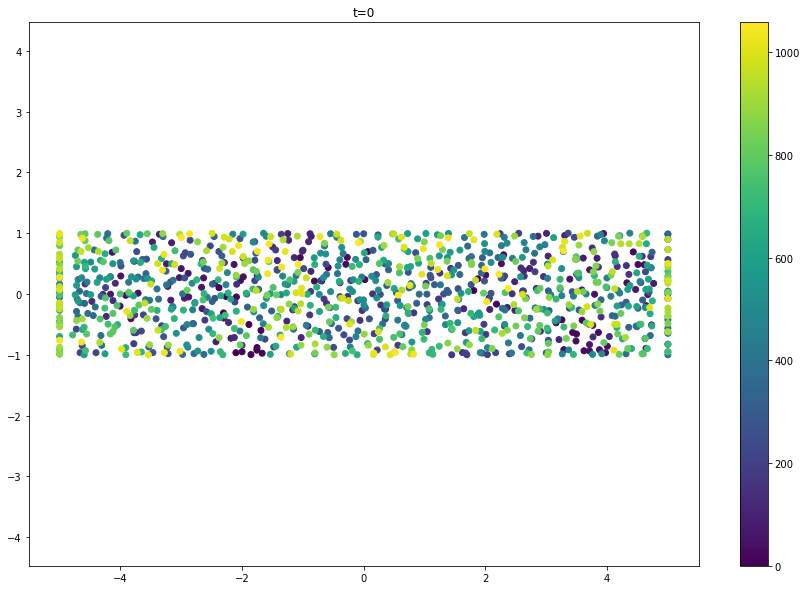

In [239]:
plot_step(0,'id')

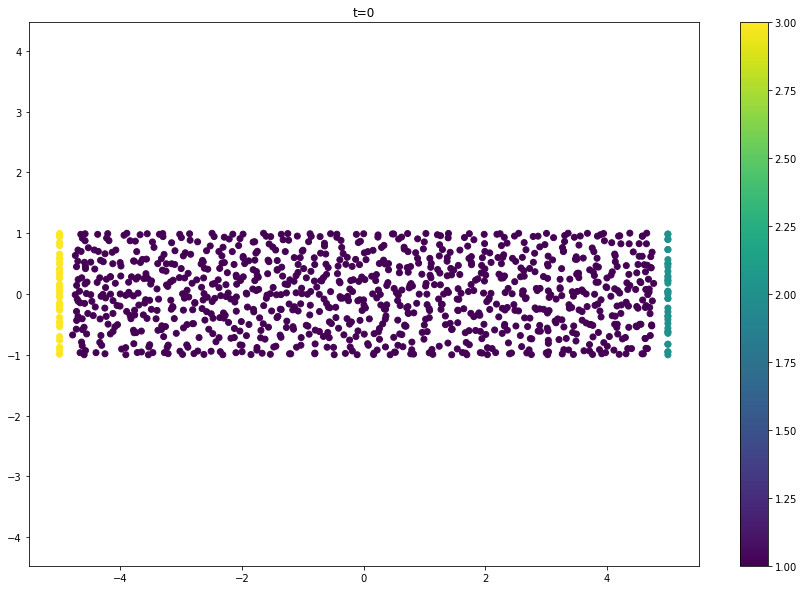

In [220]:
plot_step(0)

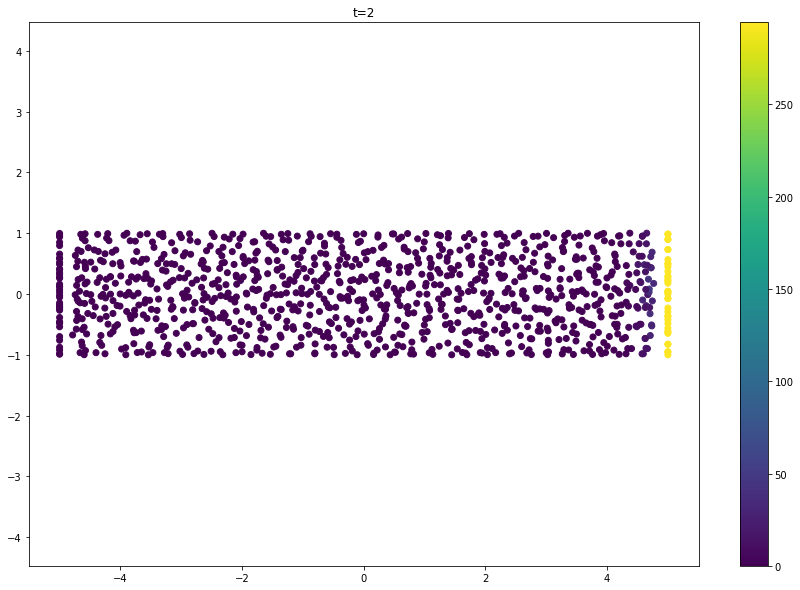

In [221]:
plot_step(2,'C[A]')

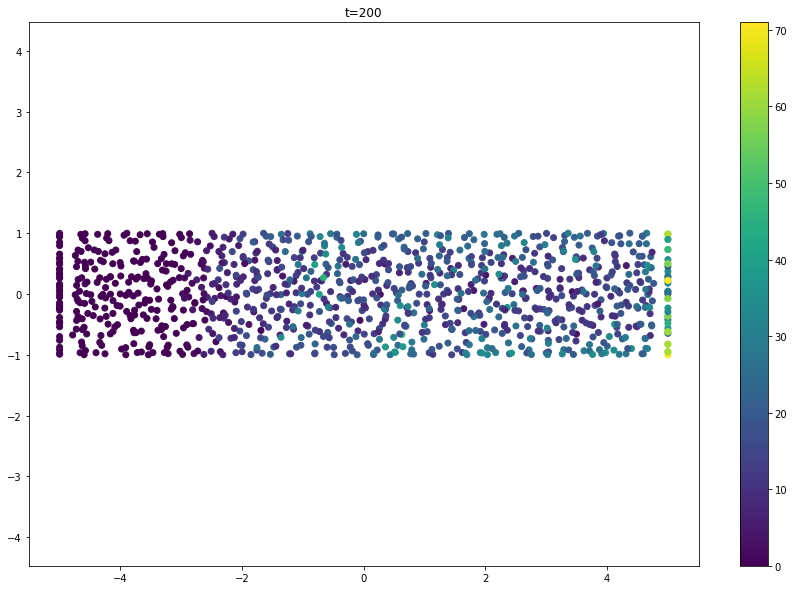

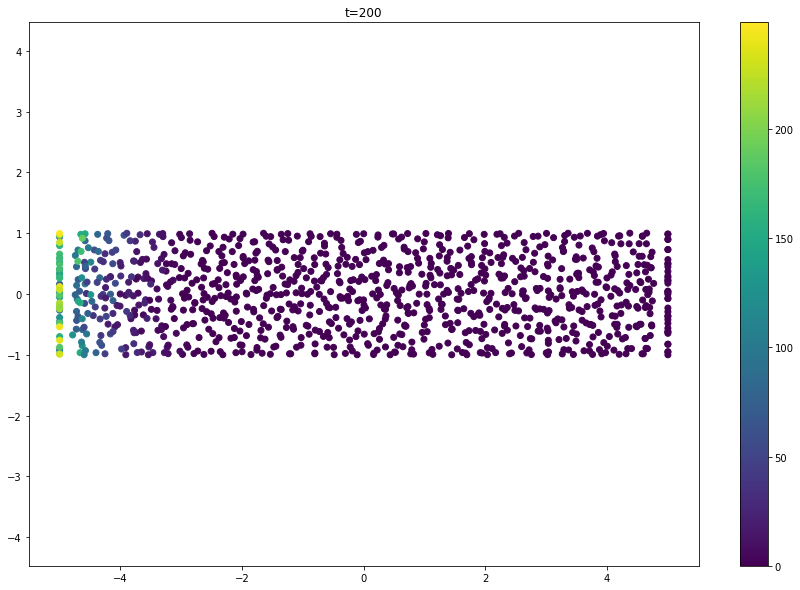

In [238]:
t=200
plot_step(t,'D[A]')
plot_step(t,'D[B]')

In [223]:
# Plot the subdomains
result.plot_property("type", 2)

In [247]:
result.plot_species("A", t_ndx=-1, deterministic=True)

In [256]:
result.plot_species("B", t_ndx=-1, deterministic=True)

In [257]:
result.plot_species("A", t_ndx=-1, size=10, concentration=True)

In [246]:
result.plot_species("B", t_ndx=-1, size=10)

In [228]:
result.plot_species("A", t_ndx=-1, size=10)

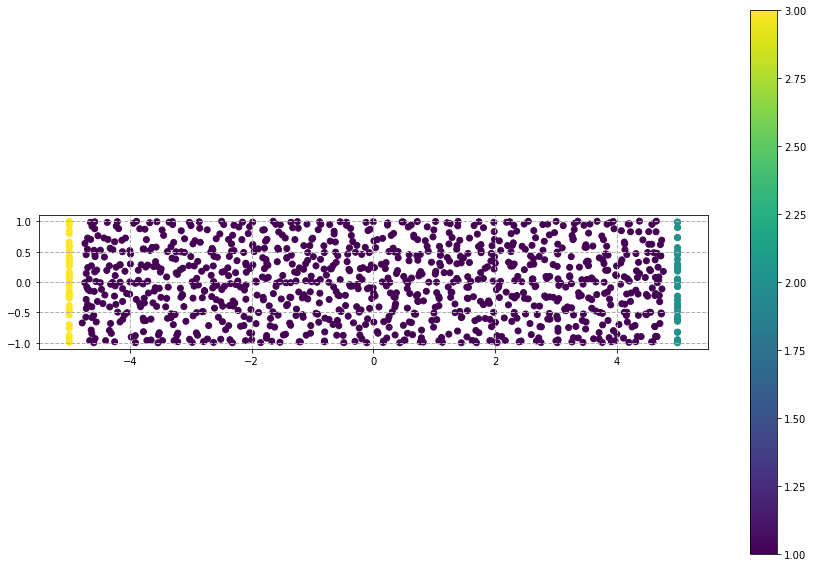

In [229]:
result.plot_property("type", use_matplotlib=True, mpl_width=15, mpl_height=10)

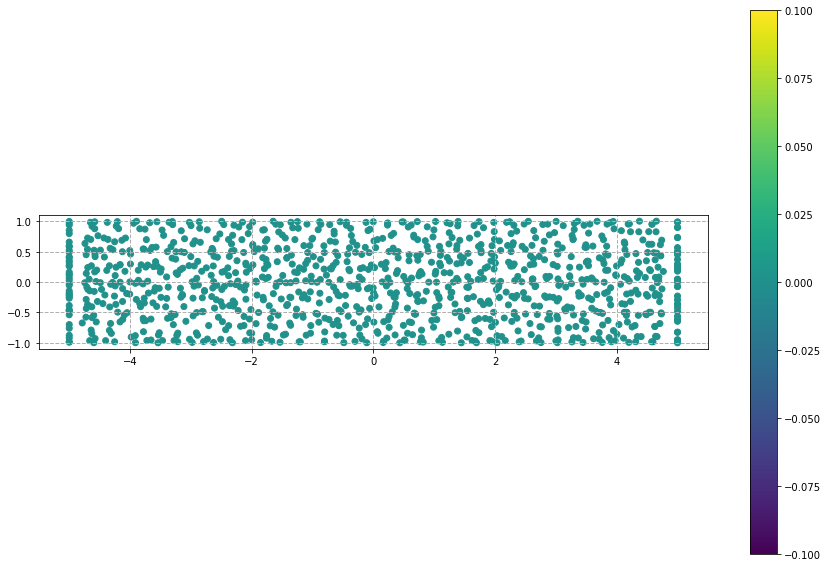

In [230]:
result.plot_species("A", deterministic=True, use_matplotlib=True, mpl_width=15, mpl_height=10)

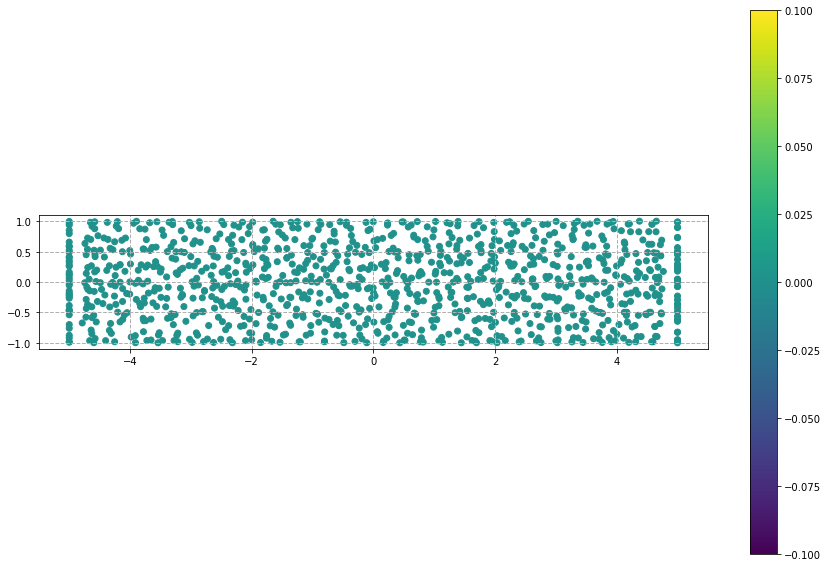

In [231]:
result.plot_species("A", use_matplotlib=True, mpl_width=15, mpl_height=10)

In [242]:
from spatialpy.Solver import Solver
sol = Solver(model, debug_level=2)
%time sol.compile()


Compiling Solver.  Build dir: /tmp/spatialpy_build_u699e58c
Creating propensity file /tmp/spatialpy_build_u699e58c/cylinder_demo3d_generated_model.c
cmd: cd /tmp/spatialpy_build_u699e58c ; make -f /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/build/Makefile ROOT=/home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine MODEL=/tmp/spatialpy_build_u699e58c/cylinder_demo3d_generated_model.c BUILD=/tmp/spatialpy_build_u699e58c

gcc -c -o linked_list.o /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/linked_list.c -I/home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall
gcc -c -o particle.o /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/particle.c -I/home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall
gcc -c -o simulate.o /home/brian/Desktop/research/SpatialPy/spatialpy/ssa_sdpd-c-simulat

In [210]:
sol.build_dir

'/tmp/spatialpy_build_2xbjas44'

In [192]:
#print(subprocess.getoutput(sol.build_dir+'/ssa_sdpd'))

In [200]:
#!/tmp/spatialpy_build_1h9cf_2u/ssa_sdpd